Goals:

1. An intuition for how and why principal component analysis works
2. The derivation from ~~first principles~~ using `numpy` of the math behind PCA
4. Discuss the assumptions behind PCA


[Reference](https://arxiv.org/pdf/1404.1100.pdf)

## What is PCA

- a simple, non-parametric method of extracting relevant information from confusing data sets
- a method for reducing a complex data set to a lower dimension
- a method for revealing hidden dynamics in data

#### Non-parametric


    this_pca = PCA(n_components=5)
    other_pca =  PCA(n_components=10)

    this_pca.fit(some_data)
    other_pca.fit(some_data)
    
If we were to run this code, then the first five components of `other_pca` will be the same as the five components of `this_pca`. The model is non-parametric i.e there are no parameters to tune. 

> Here is the perspective: we are an experimenter. We are trying to understand some phenomenon by measuring various quantities (e.g. spectra, voltages, velocities, etc.) in our system. Unfortunately, we can not figure out what is happening because the data appears clouded, unclear and even redundant. This is not a trivial problem, but rather a fundamental obstacle in empirical science. Examples abound from complex systems such as neuroscience, web indexing, meteorology and oceanography - the number of variables to measure can be unwieldy and at times even deceptive, because the underlying relationships can often be quite simple.

## A Toy Example

Pretend we are studying the motion of the physicist’s ideal spring. 

This system consists of a ball of mass $m$ attached to a massless, frictionless spring. 

The ball is released a small distance away from equilibrium (i.e. the spring is stretched). 

Because the spring is ideal, it oscillates indefinitely along the $x$-axis about its equilibrium at a set frequency.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline

<img src="https://www.evernote.com/l/AAFyWbRBljJIqqUfNcOo8SvvvPa3gCnvCsAB/image.png" width="400px">

Being ignorant experimenters we do not know any of this. 

We do not know which, let alone how many, axes and dimensions are important to measure. 

Unfortunately, because of our ignorance, we do not even know what are the real axes, so we choose three camera positions $\mathbf{a}$, $\mathbf{b}$ and $\mathbf{c}$ at some arbitrary angles with respect to the system. 

The angles between our measurements might not even be 90$^\circ$! 

Now, we record with the cameras for several minutes - an $x$ and $y$ value for the ball at each moment in time.

In [2]:
data_df = pd.read_pickle('../data/ball_on_spring.p')

In [3]:
data_df.shape

(150, 6)

In [4]:
data_df.sample(4)

,x_a,x_b,x_c,y_a,y_b,y_c
31,1.865915,2.501225,1.266401,0.800545,0.482613,2.205541
0,-1.668490,-1.314564,-0.706527,-0.676222,1.465418,-1.798437
63,-1.487033,-1.823077,-0.452888,-0.765911,1.375223,-1.522760
15,0.321551,0.998158,0.085843,0.300425,0.816985,0.501345


In these diagrams, the green arrow represents the camera.

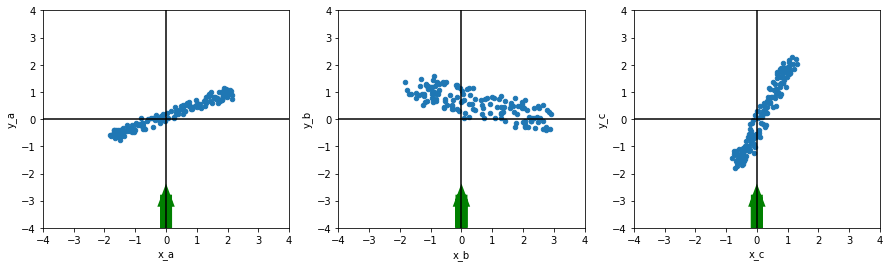

In [5]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
for i, cam in enumerate(['a', 'b', 'c']):
    x_axis = 'x_{}'.format(cam)
    y_axis = 'y_{}'.format(cam)
    data_df.plot(x_axis, y_axis, kind='scatter', ax=ax[i], xlim=(-4,4), ylim=(-4,4))
    ax[i].axvline(c='black')
    ax[i].axhline(c='black')
    ax[i].arrow(0,-4,0,1,color='green',lw=12)

## How do we get from this data set to a simple equation of $x$?

We know a-priori that if we were smart experimenters, we would have just measured the position along the x-axis with one camera. But this is not what happens in the real world. We often do not know which measurements best reflect the dynamics of our system in question. Furthermore, we sometimes record more dimensions than we actually need.

# Change of Basis


The goal of principal component analysis is to identify the most meaningful basis to re-express a data set.


In the example of the spring, the explicit goal of PCA is to determine: 

> “the dynamics are along the $x$-axis.”

### Variance and the Goal

At a high-level, our goal is to find a transformation for our data so that it is a "best expression" of the data.

Mathematically, this looks like this 

$$X' = PX$$

where $X$ is the original data and $X'$ is the transformed, "best expression" of the data. 

$P$ is a permutation or transformation matrix. 

## Example Transformation: Rotation

One example of a transformation is a rotation.

In [6]:
cam_A_df = data_df[['x_a', 'y_a']]

In [7]:
def pd_rotation(dataframe, angle):
    angle = np.pi/180*angle
    tmp_df = dataframe.copy()
    tmp_df.columns = ['x', 'y']
    tmp_df['x'] = np.cos(angle)*tmp_df['x']
    tmp_df['y'] = np.sin(angle)*tmp_df['y']
    return tmp_df

#### Measured Camera A

(-3, 3)

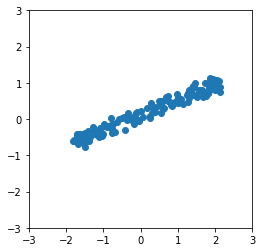

In [8]:
fig = plt.figure(figsize=(4,4))
plt.scatter(cam_A_df.x_a, cam_A_df.y_a)
plt.xlim(-3,3)
plt.ylim(-3,3)

#### Camera A Rotated 85°

(-3, 3)

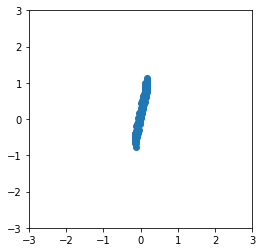

In [9]:
fig = plt.figure(figsize=(4,4))
cam_A_rot = pd_rotation(cam_A_df, 85)
plt.scatter(cam_A_rot.x, cam_A_rot.y)
plt.xlim(-3,3)
plt.ylim(-3,3)

#### Camera A Rotated -65°

(-3, 3)

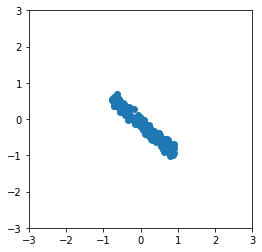

In [10]:
fig = plt.figure(figsize=(4,4))
cam_A_rot = pd_rotation(cam_A_df, -65)
plt.scatter(cam_A_rot.x, cam_A_rot.y)
plt.xlim(-3,3)
plt.ylim(-3,3)

#### The $P$ we seek will transform $X$ so that $X'$ has minimal confounding data.

## Kinds of Confounding Data 

There are essentially two kinds of confounding data that we need to minimize:

- noise
- redundancy

##### Noise in any data set must be low or - no matter the analysis technique - no information about a system can be extracted. 

## Noise

We previously considered noise in looking at the expresion of a linear model.

$$f(x) = \beta_0 + \beta_1x + \epsilon$$

Here, $\epsilon$ represents noise inherent to the model.

As outlined in the Data Generation Notebook, there are two sources of noise:

1. the actual motion of the mass is imperfect
2. the equipment is not perfect

Let's consider noise by looking at the data collected by individual cameras.

/Users/joshuacook/miniconda3/envs/summer2018/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


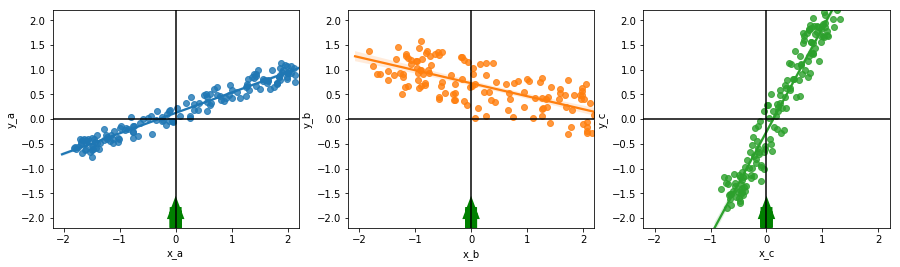

In [11]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
for i, cam in enumerate(['a', 'b', 'c']):
    x_axis = 'x_{}'.format(cam)
    y_axis = 'y_{}'.format(cam)
    sns.regplot(x_axis, y_axis, data=data_df, ax=ax[i])
    ax[i].axvline(c='black')
    ax[i].axhline(c='black')
    ax[i].set_ylim(-2.2,2.2)
    ax[i].set_xlim(-2.2,2.2)
    ax[i].arrow(0,-2.2,0,.3,color='green',lw=12)

Here we have used `sns.regplot` to plot the scatter plot of each $x,y$ pair along with a linear regression fit. 

### Line of Best Fit

We could also compute this line if we so desired. 

In [12]:
from sklearn.linear_model import LinearRegression

/Users/joshuacook/miniconda3/envs/summer2018/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [13]:
lr = LinearRegression()
lr.fit(cam_A_df[['x_a']], cam_A_df[['y_a']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
lr.coef_, lr.intercept_

(array([[0.41214217]]), array([0.12641942]))

In [15]:
cam_A_line_best_fit = lambda x: lr.intercept_ + lr.coef_*x

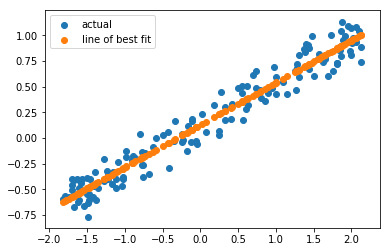

In [16]:
xx = cam_A_df.x_a.values
yy = cam_A_df.y_a.values
plt.scatter(xx, yy, label = 'actual')
plt.scatter(xx, cam_A_line_best_fit(xx), label = 'line of best fit')
plt.legend()

### Noise Level

We can calculate the level of noise by looking at the signal to noise ratio

$$SNR = \frac{\sigma^2_{signal}}{\sigma^2_{noise}}$$

To do this, we will need to calculate the variance for the signal and the variance for the noise. 

<img src="https://www.evernote.com/l/AAEGF_wOI_9AUJUqHm7JOlm75jBG5hQR_uYB/image.png" width=400px>

Recall that the mass on the spring travels in a single dimension. This dimension is the line of best fit of our data. Any deviation from this is noise. 

We can calculate the variance for the given features using `pd.DataFrame.cov()`.

### Covariances

In [17]:
cam_A = data_df[['x_a','y_a']]
cam_B = data_df[['x_b','y_b']]
cam_C = data_df[['x_c','y_c']]

In [18]:
# finding covariances for each camera along the camera's axes

cam_A_cov = cam_A.cov()
cam_B_cov = cam_B.cov()
cam_C_cov = cam_C.cov()

In [19]:
from IPython.display import display

In [20]:
display(cam_A_cov)
display(cam_B_cov)
display(cam_C_cov)

,x_a,y_a
x_a,1.691143,0.696991
y_a,0.696991,0.301972


,x_b,y_b
x_b,1.849059,-0.485615
y_b,-0.485615,0.224391


,x_c,y_c
x_c,0.340333,0.713371
y_c,0.713371,1.600043


These represent the variance along the axes defined by each camera.

In [21]:
def plot_w_x_y_var(cam, ax):
    x_axis = 'x_{}'.format(cam)
    y_axis = 'y_{}'.format(cam)

    sns.regplot(x_axis, y_axis, data=data_df, ax=ax)
    x_a_var =  data_df[x_axis].values.var()
    x_a_mean = data_df[x_axis].values.mean()
    y_a_var =  data_df[y_axis].values.var()
    y_a_mean = data_df[y_axis].values.mean()
    
    # plotting the vector origin on the mean, it's starting from the data's mean and plotting variance fr: there 
    ax.arrow(x_a_mean,y_a_mean,x_a_var, 0, lw=5)
    ax.arrow(x_a_mean,y_a_mean,0,y_a_var, lw=5)

    ax.axvline(c='black')
    ax.axhline(c='black')
    ax.set_ylim(-3,3)
    ax.set_xlim(-3,3)
    ax.arrow(0,-2.2,0,.3,color='green',lw=12)

/Users/joshuacook/miniconda3/envs/summer2018/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


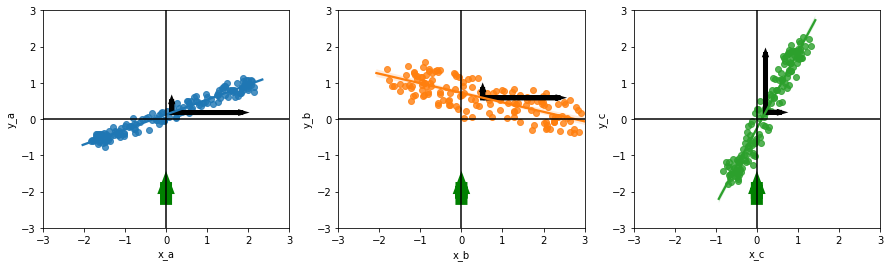

In [22]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
for i, cam in enumerate(['a', 'b', 'c']):
    plot_w_x_y_var(cam, ax[i])


### Eigendecomposition

We can find the variance of the signal and the noise by doing an eigendecomposition on the covariance matrix.

$$X_{cov} = V\Lambda V^T$$

In [23]:
eig_vals_A, eig_vecs_A = np.linalg.eig(cam_A_cov)

In [24]:
eig_vals_A

array([1.98055218, 0.01256224])

In [25]:
eig_vecs_A

array([[ 0.92354841, -0.38348185],
       [ 0.38348185,  0.92354841]])

In [26]:
some_vector = [1,2,3,4,5]
np.diag(some_vector)

array([[1, 0, 0, 0, 0],
       [0, 2, 0, 0, 0],
       [0, 0, 3, 0, 0],
       [0, 0, 0, 4, 0],
       [0, 0, 0, 0, 5]])

Take the eigenvalues and convert it to a Lambda matrix with just eigenvalues as the diags.

In [27]:
#eigen values are the variances 
#eigen vectors are the direction of the variance

V = eig_vecs_A
Lambda = np.diag(eig_vals_A)
Lambda

array([[1.98055218, 0.        ],
       [0.        , 0.01256224]])

In [28]:
cam_A_cov

,x_a,y_a
x_a,1.691143,0.696991
y_a,0.696991,0.301972


In [29]:
pd.DataFrame(V.dot(Lambda).dot(V.T))

,0,1
0,1.691143,0.696991
1,0.696991,0.301972


In [30]:
def plot_data_with_eigenvecs(cam, dataframe, evals, evecs):
    x_axis = 'x_{}'.format(cam)
    y_axis = 'y_{}'.format(cam)
    
    plt.figure(figsize=(8,8))
    sns.regplot(x_axis, y_axis, dataframe)
    
    plt.ylim(-3,3)
    plt.xlim(-3,3)
    
    plt.axvline(c='black')
    plt.axhline(c='black')
    
    mean = dataframe[[x_axis, y_axis]].mean()
    
    var_1 = evals[0]*evecs[:,0]
    var_2 = evals[1]*evecs[:,1]
    
    plt.arrow(mean[0],mean[1],*var_1, lw=5)
    plt.arrow(mean[0],mean[1],*var_2, lw=5)

/Users/joshuacook/miniconda3/envs/summer2018/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


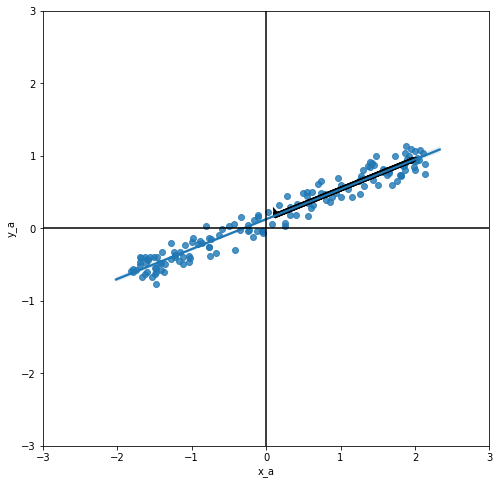

In [31]:
eig_vals_A, eig_vecs_A = np.linalg.eig(cam_A_cov)
plot_data_with_eigenvecs('a', data_df, eig_vals_A, eig_vecs_A)

/Users/joshuacook/miniconda3/envs/summer2018/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


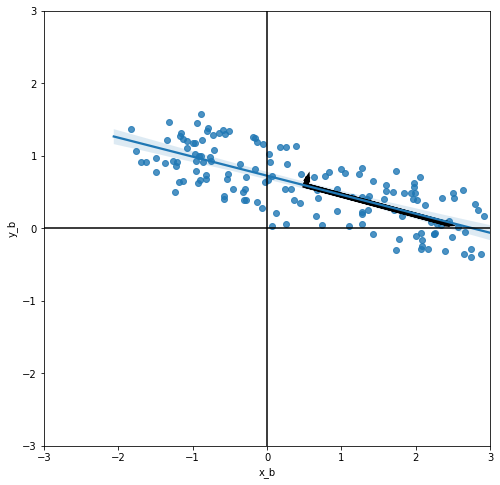

In [32]:
eig_vals_B, eig_vecs_B = np.linalg.eig(cam_B_cov)
plot_data_with_eigenvecs('b', data_df, eig_vals_B, eig_vecs_B)

In [ ]:
eig_vals_C, eig_vecs_C = np.linalg.eig(cam_C_cov)
plot_data_with_eigenvecs('c', data_df, eig_vals_C, eig_vecs_C)

### Camera A signal-to-noise

In [ ]:
eig_vals_A

In [ ]:
def signal_to_noise(var_signal, var_noise):
    return var_signal/var_noise

In [ ]:
signal_to_noise(eig_vals_A[0], eig_vals_A[1])

### Camera B signal-to-noise

In [ ]:
eig_vals_B

In [ ]:
signal_to_noise(eig_vals_B[0], eig_vals_B[1])

### Camera C signal-to-noise

In [ ]:
eig_vals_C

In [ ]:
signal_to_noise(eig_vals_C[1], eig_vals_C[0])

These calculations give us some understanding of the noise introduced by our collection tools -- the cameras.

Recall that when we created the data, we had 

    noise_factor_A = .4
    noise_factor_B = 1.1
    noise_factor_C = .5

##### Does this make sense with the signal-to-noise ratios we calculated?

## Redundancy

![](https://www.evernote.com/l/AAFmvCethNZME6R1UZOilfN2DuJPpzDuoTsB/image.png)

Redundancy is a bit trickier. There are certainly two kinds of redundancy here.

- three cameras capture the exact same phenomenon
- each camera captures two dimensions of data, where a single variable will do

In panel (c) above, it would be more meaningful to just have recorded a single variable, the linear combination $r_2 − kr_1$, instead of two variables $r_1$ and $r_2$ separately.

#### This is the idea behind dimensional reduction.
